# Código Base (Inspiração)

* link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html
* link2: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

## Bibliotecas

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# libraries
import tensorflow as tf 
import numpy as np
import os
import time
import regex as re
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from music21 import converter
import collections
import random
from sklearn.model_selection import train_test_split

# fixa para executar na CPU (determinismo)
devices = tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices(devices[0]) 

# semente aleatória
global_seed=301831
np.random.seed(global_seed)
random.seed(global_seed)
tf.random.set_seed(global_seed)

## Dados

In [2]:
# def abc_filenames(datapath='abcnotation_midi-test', count=False):
#     songs = [os.path.join(datapath, f) for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]
#     if count==True:
#         print('Found {} songs in directory'.format(len(songs)))
#     return songs

# def abc_example():
#     songs = abc_filenames(count=True)
#     with open(songs[1], 'r') as f:
#         example_song = f.read()
#     print('\nExample Song: ')
#     print(example_song[1:-2])

# def join_songs(filenames):
#     songs = []
#     for filename in filenames:
#         f = open(filename,'r', encoding='utf8')
#         text = f.read()
#         songs.append(text[1:-2])
#     songs_joined = '\n\n'.join(songs)
#     return songs_joined  

# datapath = "./data/abcnotation"
# filenames = abc_filenames(datapath)
# songs = []
# for filename in filenames[0:5000]: 
#     try:
#             f = open(filename,'r', encoding='utf8')
#             text = f.read()
#             songs.append(text)
#             f.close()
#     except:
#         print("Erro em:", filename)
#         pass
    
# # print(len(songs))
# # print(len(filenames))

# example_song = songs[1]
# print("\nExample song: ")
# print(example_song)

In [2]:
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    # print("Found {} songs in text".format(len(songs)))
    return songs

cwd = os.getcwd()
songs = []

with open(os.path.join(cwd, 'data', 'irish', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)

# # Exemplo de musica
# example_song = songs[0]
# print("\nExample song: ")
# print(example_song)

In [3]:
def clean_abc(abc_song, show_rslt=False):
    # original .abc
    text = abc_song
    new_text = text

    # # remove index field
    # new_text = re.sub('(X:).*\n', '', new_text)

    # remove title field
    new_text = re.sub('(T:).*\n', '', new_text)

    # remove composer field
    new_text = re.sub('(C:).*\n', '', new_text)

    # remove source field
    new_text = re.sub('(S:).*\n', '', new_text)

    # remove geographical origin field
    new_text = re.sub('(O:).*\n', '', new_text)

    # remove textual notes field
    new_text = re.sub('(N:).*\n', '', new_text)

    # remove identity of transcriber/source of transcription field
    new_text = re.sub('(Z:).*\n', '', new_text)

    # remove lyrics
    new_text = re.sub('([wW]:).*\n','',new_text)

    # remove comments
    new_text = re.sub('(%).*\n','',new_text)

    if show_rslt==True:
        # print results
        print('original: '+str(len(text))+' characters'+'\n' + text)
        print()
        print('after modification: '+str(len(new_text))+' characters'+'\n' + new_text)

    return new_text

# example_song2 = clean_abc(example_song)
# print(example_song2)

In [4]:
def extract_vocab(text):
    vocab = sorted(set(text))
    return {u:i for i, u in enumerate(vocab)}

for i in range(len(songs)):
    songs[i] = clean_abc(songs[i])

songs_joined = "\n\n".join(songs) 

# caracteres únicos disponíveis
vocab = extract_vocab(songs_joined)
# print("There are", len(vocab), "unique characters in the dataset")

n_chars = len(songs_joined)
n_vocab = len(vocab)
print('Total Characters:', n_chars)
print('Total Vocab:', n_vocab)

Total Characters: 171611
Total Vocab: 64


## Process the dataset for the learning task

In [5]:
# Create a mapping from character to unique index
def char2idx(string, vocab=None):
    if vocab==None:
        vocab = extract_vocab(string)
    vectorized_list = np.array([vocab[s] for s in string])
    return vectorized_list

# Create a mapping from indices to characters
def idx2char(idx, vocab):
    keys = list(vocab.keys())
    string = ''
    if isinstance(idx, collections.Iterable):
        for i in idx:
            string += keys[i]
    else:
        string += keys[idx]
    return string

In [11]:
seq_length = 100
dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
  seq_in = songs_joined[i:i + seq_length]
  seq_out = songs_joined[i + seq_length]
  dataX.append(char2idx(seq_in, vocab))
  dataY.append(char2idx(seq_out, vocab))

n_patterns = len(dataX)
print('Total Patterns:', n_patterns)

dataX

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(dataY)

# # lotes de cada musica, em strings vetorizadas, com tamanho específicos 
# def get_batch(vectorized_song, seq_length, batch_size):
#   n = len(vectorized_song) - 1

#   idx = np.random.choice(n-seq_length, batch_size)

#   input_batch = [vectorized_song[i:i+seq_length] for i in idx]
#   output_batch = [vectorized_song[i+1: i+1+seq_length] for i in idx]

#   x_batch = np.reshape(input_batch, [batch_size, seq_length])
#   y_batch = np.reshape(output_batch, [batch_size, seq_length])

#   return x_batch, y_batch

# # separa em treino e teste
# songs_train, songs_test = train_test_split(songs, train_size = 0.80)

Total Patterns: 118


## The RNN LSTM model

In [24]:
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#   model = tf.keras.Sequential([
#     # Layer 1: Embedding layer to transform indices into dense vectors 
#     #   of a fixed embedding size
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

#     # Layer 2: LSTM with `rnn_units` number of units. 
#     tf.keras.layers.LSTM(
#     units=rnn_units, 
#     activation='tanh',
#     recurrent_activation='sigmoid',
#     recurrent_initializer='glorot_uniform',
#     use_bias=True,
#     bias_initializer='zeros',
#     return_sequences=True, 
#     stateful=True
#     ),

#     # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
#     #   into the vocabulary size. 
#     tf.keras.layers.Dense(units=vocab_size)
#   ])

#   return model


# define the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [25]:
model.fit(X, y, epochs=2, batch_size=128)

Epoch 1/2
1340/1340 [==============================] - 1031s 765ms/step - loss: 2.8961
Epoch 2/2
1340/1340 [==============================] - 1091s 814ms/step - loss: 2.1816


In [45]:
import sys

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = list(dataX[start])
print("Seed (start string):")
print("\"", ''.join([idx2char(value, vocab) for value in pattern]), "\"")
# generate characters
for i in range(50):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = idx2char(index, vocab)
	seq_in = [idx2char(value, vocab) for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed (start string):
" M:C
L:1/8
K:D Mixolydian
g|afge fdd2|cABG AFDE|FEFG A3B|cBAB cdeg|!
afge fdd2|cABG AFDE|FEFG A3B|cAG "
c A2:|!

X:15
M:C
L:1/8
K:G Major

||22B  GAA||2dd
Done.


### Training the model: loss and training operations

In [8]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

# @tf.function
def train_step(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()


In [58]:
# Optimization parameters:
epochs = 2  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 20  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 # Experiment between 8 and 1024
rnn_units = 512  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)
vec_songs_train = [char2idx(song, vocab) for song in songs_train]
vec_songs_test = [char2idx(song, vocab) for song in songs_test]


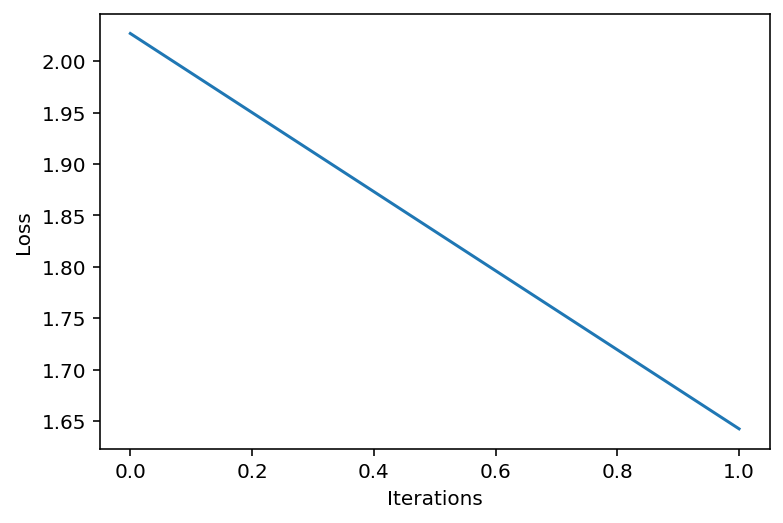

100%|██████████| 2/2 [10:38<00:00, 319.02s/it]


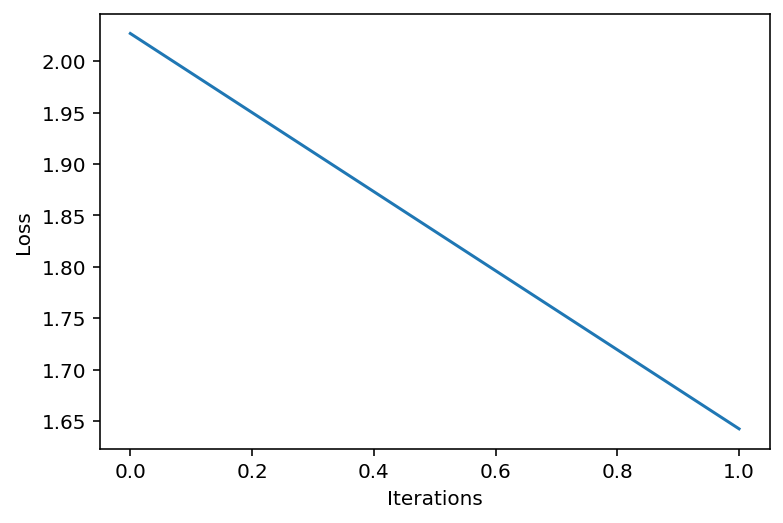

In [59]:
###################
# Begin training! #
###################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists


x_batch = []
y_batch = []
for vec_song in vec_songs_train:
    x, y = get_batch(vec_song, seq_length, batch_size)
    x_batch.append(x)
    y_batch.append(y)

for iter in tqdm(range(epochs)):

  global_loss = []

  # Grab a batch and propagate it through the network
  for i in range(len(x_batch)):
    loss = train_step(x_batch[i], y_batch[i])
    global_loss.append(loss.numpy().mean())

  # Update the progress bar
  history.append(np.mean(global_loss))
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

### Restore the latest checkpoint

In [60]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

# model.summary()

### The prediction procedure

In [84]:
def generate_text(model, start_string, vocab=vocab, generation_length=None):
  input_eval = [char2idx(s, vocab) for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()

  n = generation_length
  for i in range(n):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char(predicted_id, vocab))
    
  text = (''.join(text_generated))
    
  return text

In [86]:
y = []
y_hat = []

tqdm._instances.clear()
for i in tqdm(range(len(songs_test))):
    n = len(songs_test[i])
    n_test = round(0.8*len(songs_test[i]))
    x_test = songs_test[i][0:n_test]
    y_test = songs_test[i][n_test:n]
    y.append(y_test)

    pred = generate_text(model, start_string=x_test, vocab=vocab, generation_length=len(y_test))
    y_hat.append(pred)


 54%|█████▍    | 89/164 [01:54<01:50,  1.47s/it]

In [82]:
# BLEU
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu

def bleu(ref, gen):
    ''' 
    calculate pair wise bleu score. uses nltk implementation
    Args:
        references : a list of reference sentences 
        candidates : a list of candidate(generated) sentences
    Returns:
        bleu score(float)
    '''
    ref_bleu = []
    gen_bleu = []
    for l in gen:
        gen_bleu.append(l.split())
    for i,l in enumerate(ref):
        ref_bleu.append([l.split()])
    cc = SmoothingFunction()
    score_bleu = corpus_bleu(ref_bleu, gen_bleu, weights=(0, 1, 0, 0), smoothing_function=cc.method4)
    return score_bleu


print('BLEU =', bleu(ref=y, gen=y_hat))


# ROUGE
#rouge scores for a reference/generated sentence pair
#source google seq2seq source code.

import itertools

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  #just returning recall count in rouge, useful for our purpose
  return recall

print('ROUGE (n=2) =',rouge_n(reference_sentences=y, evaluated_sentences=y_hat, n=2))

# Perplexity
print('model categorical cross-entropy loss =', np.mean(global_loss))
print('model perplexity (2**) =', 2**(np.mean(global_loss)))
print('model perplexity (exp) =', tf.exp(np.mean(global_loss)).numpy())


BLEU = 0.0073693552855311735
ROUGE (n=2) = 0.0
model categorical cross-entropy loss = 1.6424818
model perplexity (2**) = 3.1220243810324115
model perplexity (exp) = 5.1679797


In [ ]:
# caminhos
# - aparentemente, o código gera as músicas como deveria, mas sem reprodutibilidade...
# - inserir qualquer comando de fixar semente em "get_batch()" está dando problema
# - no entanto, é possível fixar semente para peso inicial e para gerar caracteres/músicas dado o modelo com os pesos carregados (testar melhor)
# - talvez vale a pena criar alguns modelos deixando os pesos salvos, e gerar as músicas com base em uma seed determinada
# - talvez estabilizando o código, dê para realizar a computação na CPU para garantir reprodutibilidade
# próximos passos código
# - limpar/manipular arquivos ABC para brincar com predição
# - redefinir get_batch para limitar para cada arquivo .abc (objetivo: extrapolar cada música)
# - adaptar código para executar com dados do abcnotation, além do irish, claro

# https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

## AAAAAA

In [ ]:
# def generate_text2(model, start_string, vocab=vocab, y_test=None):
#   input_eval = [char2idx(s, vocab) for s in start_string]
#   input_eval = tf.expand_dims(input_eval, 0)

#   text_generated = []
#   loss = []

#   model.reset_states()
#   tqdm._instances.clear()

#   n = len(y_test)
#   for i in tqdm(range(n)):
#     predictions = model(input_eval)
#     predictions = tf.squeeze(predictions, 0)
#     output = tf.expand_dims([char2idx(s, vocab) for s in start_string[i:]+y_test[0:i]],0)
#     gen_loss = compute_loss(output, predictions)
#     loss.append(gen_loss.numpy().mean())
#     predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
#     input_eval = tf.expand_dims([predicted_id], 0)
#     text_generated.append(idx2char(predicted_id, vocab))
    
#   text = (start_string + ''.join(text_generated))
    
#   return text, loss



# n = len(songs[1]) 
# n_train = round(0.8*len(songs[1]))
# x_train = songs[1][0:n_train]
# y_train = songs[1][n_train:n]


# model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# # generated_text, test_loss = generate_text2(model, start_string=x_train, vocab=vocab, y_test=y_train)
# # generated_text
# # test_loss

# input_eval = [char2idx(s, vocab) for s in x_train]
# input_eval = tf.expand_dims(input_eval, 0)

# # output_eval = [char2idx(s, vocab) for s in y_train]
# # output_eval = tf.expand_dims(output_eval, 0) 

# # pred = model(input_eval)
# # pred = tf.squeeze(pred, 0)
# # idx2char(np.squeeze(tf.random.categorical(pred, num_samples=1).numpy()), vocab)
# # idx2char(tf.random.categorical(pred, num_samples=1)[-1,0].numpy(), vocab)
# # x_train

# # i=0
# # len(x_train[i:]+y_train[0:i+1])
# # x_batch[0]
# # y_batch[0]
# # compute_loss(output, pred).numpy().mean()
